<a href="https://colab.research.google.com/github/Kimminsu-ds/Deep-Learning-NLP-using-Tensorflow/blob/main/03_02_Word_Embedding_Word2Vec(Korean).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 러닝스푼즈 - Tensorflow를 활용한 딥러닝 자연어처리

In [1]:
# !pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 448 kB 60.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-19 12:49:57--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [2]:
import urllib.request
from konlpy.tag import Mecab
from gensim.models.word2vec import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

## 데이터 세팅

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
train_data = pd.read_table("ratings.txt")
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [4]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [5]:
# Null값 존재 유무
print(train_data.isnull().values.any())

True


In [6]:
train_data = train_data.dropna(how="any") # Null값이 존재하는 행 제거
print(train_data.isnull().values.any())   # Null값이 존재하는지 확인

False


In [7]:
print(len(train_data)) # 리뷰 개수 출력

199992


## 전처리

In [8]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
train_data[:5]

,id,document,label
0,8112052,어릴때보고지금다시봐도재밌어요ㅋㅋ,1
1,8132799,디자인을배우는학생으로외국디자이너와그들이일군전통을통해발전해가는문화산업이부러웠는데사실우...,1
2,4655635,폴리스스토리시리즈는부터뉴까지버릴께하나도없음최고,1
3,9251303,와연기가진짜개쩔구나지루할거라고생각했는데몰입해서봤다그래이런게진짜영화지,1
4,10067386,안개자욱한밤하늘에떠있는초승달같은영화,1


In [9]:
# 불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [10]:
# 형태소 분석기 mecab을 사용한 토큰화 작업 (다소 시간 소요)
mecab = Mecab()
tokenized_data = []
for sentence in train_data['document']:
  temp_X = mecab.morphs(sentence) # 토ㅓ큰화
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  tokenized_data.append(temp_X)

리뷰의 최대 길이: 74
리뷰의 평균 길이: 11.67226189047562


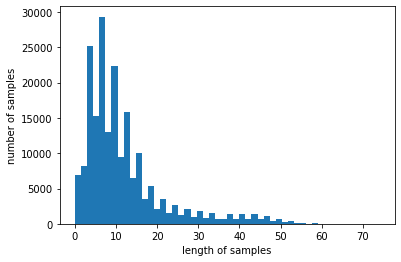

In [11]:
# 리뷰 길이 분포 확인
print("리뷰의 최대 길이:", max(len(l) for l in tokenized_data))
print("리뷰의 평균 길이:", sum(map(len, tokenized_data)) / len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

## Word2Vec 임베딩
[Gensim Word2Vec API](https://radimrehurek.com/gensim/models/word2vec.html)
- size: 워드 벡터의 특징값. 즉, 임베딩 된 벡터의 차원
- window: 컨텍스트 윈도우 크기
- min_count: 단어 최소 빈도수 제한(빈도가 적은 단어들은 학습하지 않는다)
- workers: 학습을 위한 프로세스 수
- sg
  - 0: CBOW
  - 1: Skip-gram

In [12]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [13]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(18441, 100)

In [14]:
print(model.wv.most_similar("최민식"))

[('신들린', 0.8786241412162781), ('안성기', 0.8732550740242004), ('설경구', 0.8683528304100037), ('한석규', 0.8503977060317993), ('황정민', 0.8503462672233582), ('송강호', 0.849758505821228), ('엄정화', 0.8456975221633911), ('정재영', 0.8404399156570435), ('박신양', 0.8399069309234619), ('박중훈', 0.8398081064224243)]


In [15]:
print(model.wv.most_similar("히어로"))

[('호러', 0.8720569014549255), ('슬래셔', 0.8513004183769226), ('하이틴', 0.827109694480896), ('최고봉', 0.8249409794807434), ('괴수', 0.8204753398895264), ('정통', 0.8188488483428955), ('고어', 0.8081582188606262), ('느와르', 0.804408073425293), ('블록버스터', 0.798257052898407), ('갱스터', 0.7927414774894714)]


In [16]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format("kor_w2v") # 모델 저장

## Visualization
- kor_w2v라는 Word2Vec 모델이 이미 존재한다는 가정 하에 아래 커맨드를 수행

In [23]:
%pwd

'/content'

In [22]:
%cd ..

/content


In [24]:
!python -m gensim.scripts.word2vec2tensor --input kor_w2v -- output kor_w2v

usage: word2vec2tensor.py [-h] -i INPUT -o OUTPUT [-b]
word2vec2tensor.py: error: the following arguments are required: -o/--output


### [Embedding Projector](https://projector.tensorflow.org/)
  - 위 Choose file 버튼 클릭
  - eng_w2v_tensor.tsv 파일 업로드
  - 아래 Choose file 버튼 클릭
  - eng_w2v_metadata.tsv 파일 업로드
  - 두 파일을 업로드하면 워드 임베딩 모델이 시각화